In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.collab import *
from fastai.tabular import *
from pathlib2 import Path

In [5]:
path = untar_data(URLs.ML_SAMPLE); path

PosixPath('/home/kai/.fastai/data/movie_lens_sample')

In [6]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


In [7]:
data = CollabDataBunch.from_df(ratings, seed=42)

In [13]:
??CollabDataBunch

In [14]:
learn = collab_learner(data, n_factors=50, y_range=[0, 5.5])

In [15]:
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,time
0,1.638778,1.006223,00:00
1,0.854170,0.677067,00:00
2,0.641460,0.661581,00:00


In [17]:
path = Config.data_path()/'ml-100k'
path

PosixPath('/home/kai/.fastai/data/ml-100k')

In [19]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['userID', 'movieID', 'rating', 'timestamp'])
ratings.head()

,userID,movieID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [25]:
movies = pd.read_csv(path/'u.item', delimiter='|', 
                     encoding='latin-1', header=None,
                     names=['movieID', 'title', 'date', 'N', 'url',
                           *[f'g{i}' for i in range(19)]])
movies.head()

,movieID,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [23]:
len(ratings)

100000

In [26]:
rating_movie = ratings.merge(movies[['movieID', 'title']])
rating_movie.head()

,userID,movieID,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [31]:
data = CollabDataBunch.from_df(rating_movie, seed=42,
                               valid_pct=0.1, item_name='title')

In [33]:
data.show_batch()

userID,title,target
343,One Flew Over the Cuckoo's Nest (1975),5.0
524,Brazil (1985),3.0
75,"Birdcage, The (1996)",5.0
216,Old Yeller (1957),3.0
206,Hugo Pool (1997),1.0


In [28]:
y_range = [0, 5.5]

In [34]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


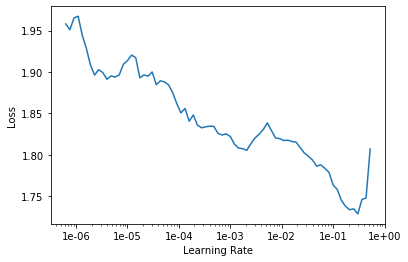

In [35]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [36]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.921981,0.956409,00:04
1,0.881619,0.882061,00:04
2,0.774044,0.831979,00:04
3,0.658968,0.813372,00:04
4,0.551606,0.811379,00:04


In [37]:
learn.save('dotprod')

In [38]:
learn.load('dotprod')

CollabLearner(data=TabularDataBunch;

Train: LabelList (90000 items)
x: CollabList
userID 196; title Kolya (1996); ,userID 63; title Kolya (1996); ,userID 226; title Kolya (1996); ,userID 154; title Kolya (1996); ,userID 306; title Kolya (1996); 
y: FloatList
3.0,3.0,5.0,3.0,5.0
Path: .;

Valid: LabelList (10000 items)
x: CollabList
userID 498; title Casino (1995); ,userID 642; title Pocahontas (1995); ,userID 58; title 2001: A Space Odyssey (1968); ,userID 495; title Cat People (1982); ,userID 618; title Philadelphia (1993); 
y: FloatList
3.0,5.0,4.0,3.0,3.0
Path: .;

Test: None, model=EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=FlattenedLoss of MSELoss(), metrics=[], true_wd=True, bn_wd=True, wd=0.1, train_bn=True, path=PosixPath('.'), model_dir='models', callback_fns=[functools.partial(<clas

In [43]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [44]:
g = rating_movie.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:20]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)', 'Raiders of the Lost Ark (1981)', 'Godfather, The (1972)',
       'Pulp Fiction (1994)', 'Twelve Monkeys (1995)', 'Silence of the Lambs, The (1991)', 'Jerry Maguire (1996)',
       'Chasing Amy (1997)', 'Rock, The (1996)', 'Empire Strikes Back, The (1980)', 'Star Trek: First Contact (1996)'],
      dtype=object)

In [42]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [46]:
mean_ratings = rating_movie.groupby('title')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i, b in zip(top_movies, movie_bias)]

In [48]:
item0 = lambda o:o[0]

In [49]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3478),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.2945), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2874), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2813),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2806), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2411), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2307), 'Beautician and the Beast, The (1997)', 2.313953488372093),
 (tensor(-0.2258), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2172), 'Grease 2 (1982)', 2.0),
 (tensor(-0.2170), "Joe's Apartment (1996)", 2.2444444444444445),
 (tensor(-0.2156), 'Leave It to Beaver (1997)', 1.8409090909090908),
 (tensor(-0.2144), 'Thinner (1996)', 2.4489795918367347),
 (tensor(-0.2123), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2065), 'Stuart Saves His Family (1995)', 2.125),
 (tensor(-0.2036), 'Barb Wire (1